# Green-Ampt model for infiltraion and runoff

by Xiaofeng Liu, Ph.D., P.E.
Associate Professor

Department of Civil and Environmental Engineering

Institute of Computational and Data Sciences

Penn State University

223B Sackett Building, University Park, PA 16802

Web: http://water.engr.psu.edu/liu/

(with contribution from Dapeng Feng, who was the TA for CE 497 in Fall 2019)

## Introduction
This notebook demonstrates the root finding methods on how to calculate the infiltration process based on the Green-Ampt model. During rainfall, water will infiltrate into the soil. As water moves down, a so-called "wetting front" marches downward too. If the rainfall is so intense and exceedst the infiltration capacity of soil, water will start to accumulate or "pond" on the surface and generate runoff. Based on this simplified phyiscal description, there are several models to capture the processes. The Green-Ampt model is one proposed in 1911 and still used today. 

Good references for the Green-Ampt model include the following:
```
- L. W. Mays (2010). Water Resources Engineering, 2nd edition, John Wiley & Sons, Inc.
- V. T. Chow, D. R. Maidment, and L. W. Mays (1988). Applied Hydrology, McGraw-Hill, New York
```

In the following, the Green-Ampt model is briefly introduced. One quantity of interest is the cumulative infiltration $F(t)$ as a function of time $t$. As you will see, we need to solve a nonlinear algebraic equation for $F(t)$. The root of the cumulative infiltration equation can not be sloved directily. Therefore, this is a good case to use the root finding methods. In this example, the secant method in the Scipy package is used. It can be adapted to use other methods covered in class.   

## The Green-Ampt method
Figure 1 shows the variables defined in the Green-Ampt model and Figure 2 plots the infiltration rate and cumulative infiltration of a typical infiltration process. 

<img src="GA_definition.png" width="400"/>

<h3 align="center">Figure 1. Variables in the Green-Ampt infiltartion model (adapted from Chow et al. (1988)).</h3> 

<img src="GA_curves.png" width="400"/>

<h3 align="center">Figure 2. Rainfall infiltration rate and cumulative infiltration (adapted from Larry Mays (2010)).</h3> 

Applying Darcy's law to the model in Figure 1, we can get
\begin{equation}
f = K \left(\frac{\psi+L}{L}\right)
\end{equation}
where $f$ is the infiltration rate, $K$ is the hydraulic conductivity, and $\psi$ is the wetting front soil suction head, and $L$ is the length of the wetted zone. This equation neglects the depth of surface ponding $h_0$, which is comparitively small to other terms. The infiltration rate is defined as $f = \frac{dF}{dt}$. Then, the above equation can be expressed as a differential equation with one unknown variable, i.e., the cumulative infiltration $F$
\begin{equation}
\frac{dF}{dt} = K \left(\frac{\psi+L}{L}\right)
\end{equation}
From mass balance, the infilted water is used to wet the soil between the surface and the wetting front (minus the initial moisture). This means $L=F/\Delta \theta$. Plugging this into the previous equation, we get
\begin{equation}
\frac{dF}{dt} = K \left(\frac{\psi \Delta \theta+F}{F}\right)
\end{equation}
This is a simple first-order ordinary differential equation (ODE) subject to the initial condition of 
\begin{equation}
F(t=0) = 0
\end{equation}
i.e. there is no infiltration at the beginning. One can use any numerical methods covered in the ODE chapter to solve this problem. Luckily, there is an analytical solution. Integrating the ODE with the use of the initial condition, one can get
\begin{equation}
F(t) = K t + \psi\Delta\theta\ln\left(1+\frac{F(t)}{\psi\Delta\theta}\right)
\end{equation}
Unluckily, there is no explicit solution for $F(t)$. To get $F(t)$, we have to solve the above equation using a root finding method. 

Before we show how to solve the problem using root finding method, other parameters in the problem have to be defined and specified. The effective saturation $S_e$ is defined as
\begin{equation}
S_e = \frac{\theta-\theta_r}{\eta-\theta_r}
\end{equation}
where $\theta$ is the soil moisture, $\theta_r$ is the residual moisture content, and $\eta$ is the porosity. $\theta_e=\eta-\theta_r$ is called the effective porosity. For the initial condition, $\theta=\theta_i$, thus $\theta_i-\theta_r=S_e\theta_e$. The change of the moisture $\Delta\theta$ can be derived as
\begin{equation}
   \Delta\theta = \eta-\theta_i = \eta - (S_e\theta_e+\theta_r) = (1-S_e) \theta_e
\end{equation}


## The Green-Ampt method example

This is the modified example similar to that in Mays (2010), which uses the Green-Ampt method to evaluate the infiltration rate and cumulative infiltration depth for a silty clay soil from 0 to 8 hr. The initial effective saturation $S_e$ is 0.15. For a silty clay soil, $\theta_e=0.45$, $\psi=30 cm$, and $K=0.04 cm/hr$.

In [19]:
import numpy as np
from scipy import optimize
import matplotlib.pyplot as plt

# Green Ampt model F=K*t+psi*dtheta*ln(1+F/(psi*dtheta))
def greenampt(F, t, K=K, psi=psi, dtheta=dtheta):
    
    y = -F+K*t+psi*dtheta*np.log(1+F/(psi*dtheta))
    return y

# SECANT method to find the root by calling functions in 
# the optimize package. Without passing the first order derivative,
# the "newton" funciton uses the SECANT method.
def getroot(t, finit):
    fun = lambda F: greenampt(F, t) 
    Froot = optimize.newton(fun, finit)
    return Froot

# define parameters
K = 0.04        # hydraulic conductivity in cm/hr
theta_e = 0.45  # effective porosity: porosit - residual moisture content
Se = 0.15       # initial effective saturation
psi = 30        # wetting front soil suction head in cm 

dtheta = (1-Se)*theta_e # calculate delta moisture

trange = np.arange(0.0, 8.1, 0.1) # time range in hr
F = np.zeros(len(trange)) # cumulative infiltration

for i in range(len(trange)):
    t = trange[i]
    fg=K*t # initial guess of F(t)=Kt
    F[i] = getroot(t, fg) # calculate cumulative infiltration

# calculate infiltration rate. In the denominator, 1e-9 is 
# added to avoid the division-by-zero error (because F(t=0)=0).
f = K*(psi*dtheta/(F+1e-9)+1) 


### Plot the simulated infiltration rate and cumulative inflitration.

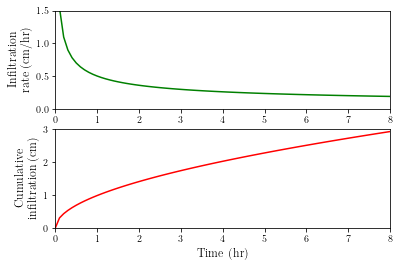

In [20]:
plt.rc('text', usetex=True)  #allow the use of Latex for math expressions and equations
plt.rc('font', family='serif') #specify the default font family to be "serif"

fig = plt.figure()

# infiltration rate
plt.subplot(2,1,1)
plt.plot(trange, f, color='green')
plt.xlabel('Time (hr)',fontsize=12)
plt.ylabel('Infiltration \n rate (cm/hr)',fontsize=12)
plt.xlim([0,8])
plt.ylim([0,1.5])

# cumulative infiltration
plt.subplot(2,1,2)
plt.plot(trange, F, color='red')
plt.xlabel('Time (hr)',fontsize=12)
plt.ylabel('Cumulative \n infiltration (cm)',fontsize=12)
plt.xlim([0,8])
plt.ylim([0,3])

plt.show()